## Домашняя работа №3

Обучить СНС с помощью Transfer Learning на датасете Food-101.
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow].

### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.2.0


### Download and prepare the Food-101 dataset

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

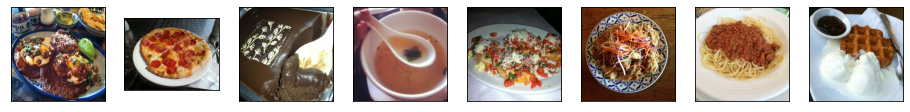

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(8))]

fig = plt.figure(figsize=(16,8))
for i in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(some_samples[i])
    plt.xticks([]), plt.yticks([])
plt.show()

### Build data pipeline

In [5]:
INP_SIZE = 160
NUM_EPOCHS = 2
BATCH_SIZE = 64

In [6]:
def convert(image, label):
    image = tf.cast(image, tf.float32)/127. - 1.
    return tf.image.resize(image, (INP_SIZE, INP_SIZE)), label

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)           
    image = tf.image.random_brightness(image, max_delta=0.5) 
    image = tf.image.random_flip_up_down(image)              

    return image,label

In [8]:
train_ds = train_ds.map(convert)

augm = train_ds.map(augment)
train_ds = train_ds.concatenate(augm)

In [9]:
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(convert)
test_ds = test_ds.batch(128, drop_remainder=True)

### Prepare CNN model

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

In [11]:
base_model

### Model learning

In [12]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
])

In [13]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
%%time

history = model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=test_ds)

Epoch 1/2
2130/2130 [==============================] - 1197s 562ms/step - loss: 2.2898 - accuracy: 0.4445 - val_loss: 1.7251 - val_accuracy: 0.5840
Epoch 2/2
2130/2130 [==============================] - 1196s 561ms/step - loss: 1.3398 - accuracy: 0.6477 - val_loss: 1.5980 - val_accuracy: 0.6280
CPU times: user 41min 24s, sys: 11min, total: 52min 25s
Wall time: 40min 13s


### Visualization

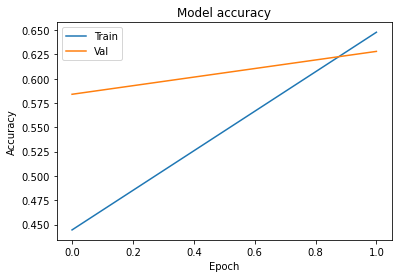

In [16]:
# accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

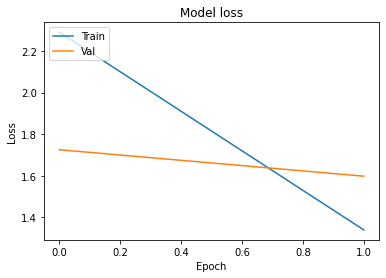

In [17]:
# loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [18]:
model.evaluate(test_ds)

59/59 [==============================] - 22s 380ms/step - loss: 1.5975 - accuracy: 0.6284


[1.5974973440170288, 0.6284428238868713]

### Prediction for ready image

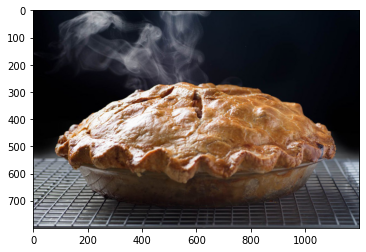

In [22]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('image.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [23]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: apple_pie
